# Forecasting NBA Game Statistics for Players in Upcoming Games

# Dataset
The dataset is from the 2022-23 and 2023-24 NBA seasons. It contains the game logs for every player.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('nba-player-gamelogs.csv')
df['dateUTC'] = pd.to_datetime(df['dateUTC'])
df

,season,dateUTC,playerTeamId,opposingTeamId,playerId,position,isStarter,minutes,points,assists,...,blocks,turnovers,fieldGoalsAttempted,fieldGoalsMade,freeThrowsAttempted,freeThrowsMade,fouls,threesAttempted,threesMade,gamescore
0,2022,2023-03-31,1610612755,1610612761,1629001,PG,1,32.600000,13,3,...,1,1,9,5,4,3,2,3.0,0.0,13.9
1,2022,2023-03-31,1610612755,1610612761,200782,PF,1,25.716667,9,1,...,0,1,7,3,0,0,2,6.0,3.0,6.8
2,2022,2023-03-31,1610612755,1610612761,203954,C,1,33.566667,25,1,...,1,5,13,7,12,11,3,2.0,0.0,17.5
3,2022,2023-03-31,1610612755,1610612761,1630178,SG,1,36.516667,13,6,...,0,0,8,5,1,1,2,4.0,2.0,12.8
4,2022,2023-03-31,1610612755,1610612761,201935,SG,1,37.100000,23,11,...,1,6,14,9,2,2,2,6.0,3.0,21.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,2023,2024-02-23,1610612759,1610612758,1631104,PG,0,16.916667,4,1,...,0,1,4,1,2,2,2,2.0,0.0,1.2
63013,2023,2024-02-23,1610612759,1610612758,1626224,SF,0,11.300000,5,3,...,0,0,4,2,0,0,1,2.0,1.0,5.3
63014,2023,2024-02-23,1610612759,1610612758,1631103,PG,0,13.350000,5,2,...,0,1,6,2,0,0,0,2.0,1.0,3.3
63015,2023,2024-02-23,1610612759,1610612758,1628984,PG,0,0.000000,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


# Feature Engineering

In [2]:

def calculate_average_stats(row):
    """
    Calculate the weighted average for each player's game statistic, such as rebounds.
    Older games are weighted exponentially less recent games. If the player is starting,
    only consider what the player averages as a starter. If the player is a bench player,
    only consider what the player averages as a bench player.
    """
    
    # Gets all the games previously played by the player
    prev_gms = (df[(df['dateUTC'] < row['dateUTC']) & (df['playerId'] == row['playerId'])]
                .sort_values(by='dateUTC'))

    # The stats whose weighted averages will be taken.
    stats = {'fieldGoalsAttempted': None, 'fieldGoalsMade': None, 'threesMade': None, 
             'freeThrowsAttempted': None, 'freeThrowsMade': None, 'points': None, 'steals': None, 
             'blocks': None, 'assists': None, 'reboundsTotal': None, 'reboundsOffensive': None,
             'reboundsDefensive': None, 'turnovers': None, 'fouls': None}
        
    for stat in stats.keys():
        if row['isStarter']:
            player_start_games = df[(df['dateUTC'] < row['dateUTC']) & (df['isStarter'])
                                    & (df['playerId']==row['playerId'])]
            if len(player_start_games) == 0:
                # If there is no sample of the player as a starter, use the average of the
                # players that start and play the player's position.
                stats[stat] = df[(df['dateUTC'] < row['dateUTC']) & (df['isStarter']) 
                                 & (df['position']==row['position'])][stat].mean()
            else:
                # If there is a sample of the player as a starter, use the average they got
                # as a starter.
                weights = 0.98 ** (row['dateUTC'] - player_start_games['dateUTC']).dt.days
                stats[stat] = np.sum(weights * player_start_games[stat]) / np.sum(weights)
        else:
            player_bench_games = df[(df['dateUTC'] < row['dateUTC']) & ~(df['isStarter']) 
                                    & (df['playerId']==row['playerId'])]
            if len(player_bench_games) == 0:
                # If there is no sample of the player as a bench player, use the average of the
                # bench players that play the player's position.
                stats[stat] = df[(df['dateUTC'] < row['dateUTC']) & ~(df['isStarter']) 
                                 & (df['position']==row['position'])][stat].mean()
            else:
                # If there is a sample of the player as a bench player, use the average they got
                # as a bench player.
                weights = 0.98 ** (row['dateUTC'] - player_bench_games['dateUTC']).dt.days
                stats[stat] = np.sum(weights * player_bench_games[stat]) / np.sum(weights)
    
    return pd.Series(stats)
    
df[['fieldGoalsAttemptedAvg', 'fieldGoalsMadeAvg', 'threesMadeAvg',
    'freeThrowsAttemptedAvg', 'freeThrowsMadeAvg', 'pointsAvg', 'stealsAvg', 'blocksAvg',
   'assistsAvg', 'reboundsTotalAvg', 'reboundsOffensiveAvg', 'reboundsDefensiveAvg', 
    'turnoversAvg', 'foulsAvg']
  ] = df.apply(calculate_average_stats, axis=1)
df

,season,dateUTC,playerTeamId,opposingTeamId,playerId,position,isStarter,minutes,points,assists,...,freeThrowsMadeAvg,pointsAvg,stealsAvg,blocksAvg,assistsAvg,reboundsTotalAvg,reboundsOffensiveAvg,reboundsDefensiveAvg,turnoversAvg,foulsAvg
0,2022,2023-03-31,1610612755,1610612761,1629001,PG,1,32.600000,13,3,...,1.244876,9.888023,1.642905,0.553465,2.476589,3.776857,0.865903,2.910954,1.532870,2.867027
1,2022,2023-03-31,1610612755,1610612761,200782,PF,1,25.716667,9,1,...,0.203882,3.137326,0.620015,0.161646,0.723885,3.809372,1.208380,2.600992,0.371039,2.188272
2,2022,2023-03-31,1610612755,1610612761,203954,C,1,33.566667,25,1,...,10.379759,32.973078,0.990694,1.878294,4.260504,10.224768,1.703204,8.521564,3.286537,2.946077
3,2022,2023-03-31,1610612755,1610612761,1630178,SG,1,36.516667,13,6,...,2.968052,23.269807,0.972863,0.117820,3.818701,3.463584,0.379521,3.084063,1.164019,2.083105
4,2022,2023-03-31,1610612755,1610612761,201935,SG,1,37.100000,23,11,...,5.621317,20.501392,1.304243,0.434246,10.969598,6.286254,0.905422,5.380832,3.211837,1.819068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,2023,2024-02-23,1610612759,1610612758,1631104,PG,0,16.916667,4,1,...,0.740943,4.051391,0.606018,0.074832,2.678541,1.016884,0.173729,0.843155,0.808912,1.389421
63013,2023,2024-02-23,1610612759,1610612758,1626224,SF,0,11.300000,5,3,...,0.563879,6.484666,0.577447,0.167787,1.569807,2.572433,0.309289,2.263144,0.693424,1.465709
63014,2023,2024-02-23,1610612759,1610612758,1631103,PG,0,13.350000,5,2,...,0.440537,5.477123,0.277347,0.047403,1.541270,1.324032,0.334363,0.989669,0.680901,0.740783
63015,2023,2024-02-23,1610612759,1610612758,1628984,PG,0,0.000000,0,0,...,0.061002,0.613305,0.036691,0.006379,0.221583,0.367264,0.025126,0.342138,0.033909,0.053266


In [3]:
def calculate_opp_stat_rating(row):
    
    # The defensive rating's will be calculated for these stats
    stats = {'fieldGoalsAttempted': None, 'fieldGoalsMade': None, 
             'threesMade': None, 'freeThrowsAttempted': None, 'freeThrowsMade': None,
             'points': None, 'steals': None, 'blocks': None,
            'assists': None, 'reboundsTotal': None, 'reboundsOffensive': None,
             'reboundsDefensive': None, 'turnovers': None, 'fouls': None}
    
    # All games the opposing team has played over the previous 50 days.
    opp_gms = df[(df['dateUTC'] < row['dateUTC']) & 
                 (df['dateUTC'] > (row['dateUTC'] - timedelta(days=50))) 
                 & (df['opposingTeamId'] == row['opposingTeamId'])
                 & (df['isStarter']==row['isStarter'])]
    
    for stat in stats.keys():
        # If the opponent has not played 20 games yet in the season, use all their games
        # from last season and the current season to estimate the opponent's rating
        if len(opp_gms['dateUTC'].unique()) < 20:
            opp_gms = df[(df['dateUTC'] < row['dateUTC']) 
                         & (df['opposingTeamId'] == row['opposingTeamId'])]
            
        # Get the total number of the stat accumulated by players with the given position against 
        # this team and divide by the total minutes played by those players
        
        stats[stat] = (opp_gms[opp_gms['position']==row['position']][stat].sum()
                        / opp_gms[opp_gms['position']==row['position']]['minutes'].sum())
    return pd.Series(stats)
    
df[['fieldGoalsAttemptedOppDRating', 'fieldGoalsMadeOppDRating', 
    'threesMadeOppDRating', 'freeThrowsAttemptedOppDRating', 'freeThrowsMadeOppDRating',
   'pointsOppDRating', 'stealsOppDRating', 'blocksOppDRating', 'assistsOppDRating', 
    'reboundsTotalOppDRating', 'reboundsOffensiveOppDRating', 'reboundsDefensiveOppDRating',
    'turnoversOppDRating', 'foulsOppDRating']] = df.apply(calculate_opp_stat_rating, axis=1)
df

C:\Users\sfedd\AppData\Local\Temp\ipykernel_19504\625961790.py:26: RuntimeWarning: invalid value encountered in scalar divide
  stats[stat] = (opp_gms[opp_gms['position']==row['position']][stat].sum()


,season,dateUTC,playerTeamId,opposingTeamId,playerId,position,isStarter,minutes,points,assists,...,freeThrowsMadeOppDRating,pointsOppDRating,stealsOppDRating,blocksOppDRating,assistsOppDRating,reboundsTotalOppDRating,reboundsOffensiveOppDRating,reboundsDefensiveOppDRating,turnoversOppDRating,foulsOppDRating
0,2022,2023-03-31,1610612755,1610612761,1629001,PG,1,32.600000,13,3,...,0.071504,0.423523,0.044002,0.017876,0.202136,0.108631,0.020626,0.088005,0.079754,0.079754
1,2022,2023-03-31,1610612755,1610612761,200782,PF,1,25.716667,9,1,...,0.079021,0.461650,0.020795,0.020795,0.085260,0.180917,0.039511,0.141406,0.062385,0.064465
2,2022,2023-03-31,1610612755,1610612761,203954,C,1,33.566667,25,1,...,0.103476,0.580013,0.016338,0.021785,0.093946,0.246437,0.061269,0.185168,0.063992,0.080330
3,2022,2023-03-31,1610612755,1610612761,1630178,SG,1,36.516667,13,6,...,0.067546,0.451914,0.025732,0.020907,0.112576,0.119009,0.017691,0.101319,0.069154,0.059505
4,2022,2023-03-31,1610612755,1610612761,201935,SG,1,37.100000,23,11,...,0.067546,0.451914,0.025732,0.020907,0.112576,0.119009,0.017691,0.101319,0.069154,0.059505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,2023,2024-02-23,1610612759,1610612758,1631104,PG,0,16.916667,4,1,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045
63013,2023,2024-02-23,1610612759,1610612758,1626224,SF,0,11.300000,5,3,...,0.058209,0.317910,0.031343,0.013433,0.062687,0.143284,0.026866,0.116418,0.044776,0.107463
63014,2023,2024-02-23,1610612759,1610612758,1631103,PG,0,13.350000,5,2,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045
63015,2023,2024-02-23,1610612759,1610612758,1628984,PG,0,0.000000,0,0,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045


In [7]:
# Get the dataset for machine learning.
# Only use game logs from the most recent rgular season. As of this comment, the most recent
# regular season is the 2023-24 season. 
ml_df = (df[df['season'] == max(df['season'].unique())]
         .drop(columns=['season', 'dateUTC', 'playerTeamId', 'opposingTeamId', 'playerId',
                       'position', 'isStarter', 'minutes'])
         .dropna().copy())

ml_df

,points,assists,reboundsDefensive,reboundsOffensive,reboundsTotal,steals,blocks,turnovers,fieldGoalsAttempted,fieldGoalsMade,...,freeThrowsMadeOppDRating,pointsOppDRating,stealsOppDRating,blocksOppDRating,assistsOppDRating,reboundsTotalOppDRating,reboundsOffensiveOppDRating,reboundsDefensiveOppDRating,turnoversOppDRating,foulsOppDRating
52,16,0,3,0,3,1,0,1,10,6,...,0.083307,0.558850,0.038182,0.010413,0.118018,0.161407,0.032976,0.128431,0.052067,0.072893
53,26,9,3,1,4,3,0,2,13,9,...,0.103938,0.528006,0.033260,0.074835,0.085922,0.289641,0.078993,0.210648,0.056819,0.083150
54,22,1,5,0,5,1,0,0,12,6,...,0.102696,0.577664,0.044012,0.012837,0.130204,0.095360,0.018339,0.077022,0.055016,0.067853
55,15,7,1,0,1,1,0,1,11,6,...,0.110226,0.616978,0.030062,0.020041,0.191821,0.130267,0.018610,0.111657,0.065849,0.057260
56,12,6,3,1,4,2,0,2,6,5,...,0.078243,0.486378,0.044408,0.004229,0.128996,0.109964,0.025376,0.084587,0.044408,0.103620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,4,1,0,1,1,0,0,1,4,1,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045
63013,5,3,2,0,2,0,0,0,4,2,...,0.058209,0.317910,0.031343,0.013433,0.062687,0.143284,0.026866,0.116418,0.044776,0.107463
63014,5,2,2,1,3,0,0,1,6,2,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045
63015,0,0,0,0,0,0,0,0,0,0,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045


# Data Visualization

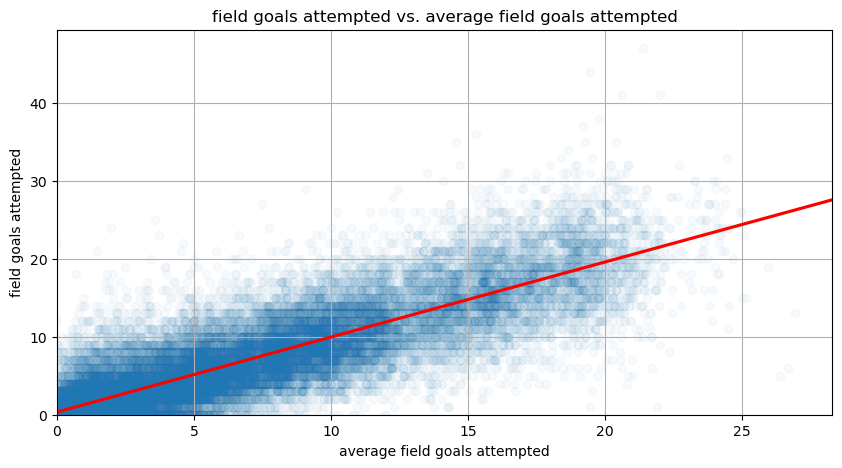

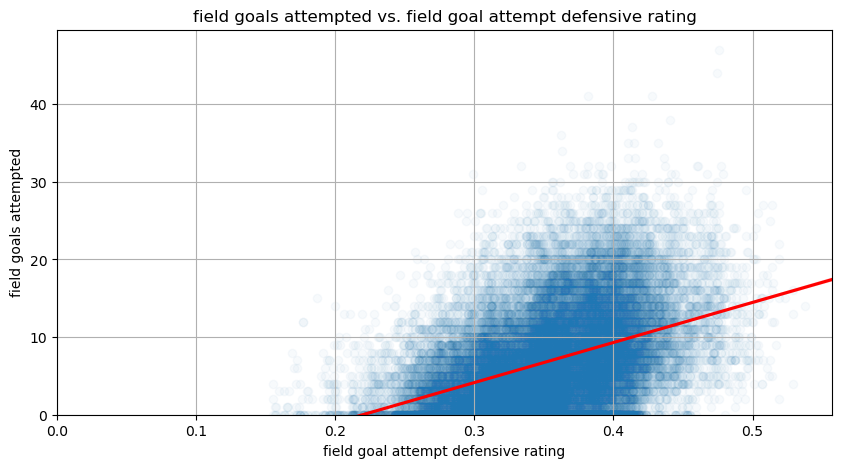

In [11]:
# Plot scatter plot of field goals attempted vs. average field goals attempted
plt.figure(figsize=(10, 5))
sns.regplot(data=ml_df, x='fieldGoalsAttemptedAvg', y='fieldGoalsAttempted', 
            scatter_kws={'alpha':0.03}, line_kws={'color':'red'}, truncate=False)
plt.title(f'field goals attempted vs. average field goals attempted')
plt.xlabel('average field goals attempted')
plt.ylabel('field goals attempted')
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

# Plot scatter plot of field goals attempted vs. field goal attempt defensive rating
plt.figure(figsize=(10, 5))
sns.regplot(data=ml_df, x='fieldGoalsAttemptedOppDRating', y='fieldGoalsAttempted', 
            scatter_kws={'alpha':0.03}, line_kws={'color':'red'}, truncate=False)
plt.title(f'field goals attempted vs. field goal attempt defensive rating')
plt.xlabel('field goal attempt defensive rating')
plt.ylabel('field goals attempted')
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

# Train the Linear Regressions with Machine LEarning

In [15]:
# Player averages of each statistic to be predicted.
player_averages = [
    'fieldGoalsAttemptedAvg', 'fieldGoalsMadeAvg', 'threesMadeAvg',
    'freeThrowsAttemptedAvg', 'freeThrowsMadeAvg', 'pointsAvg', 'assistsAvg',
    'reboundsTotalAvg', 'reboundsOffensiveAvg', 'reboundsDefensiveAvg',
    'turnoversAvg', 'stealsAvg', 'blocksAvg', 'foulsAvg'
]

# Opposing defense's rating against each statistic to be predicted.
defensive_ratings = [
    'fieldGoalsAttemptedOppDRating', 'fieldGoalsMadeOppDRating',
    'threesMadeOppDRating', 'freeThrowsAttemptedOppDRating', 'freeThrowsMadeOppDRating',
    'pointsOppDRating', 'assistsOppDRating', 'reboundsTotalOppDRating', 
    'reboundsOffensiveOppDRating', 'reboundsDefensiveOppDRating', 'turnoversOppDRating', 
    'stealsOppDRating', 'blocksOppDRating', 'foulsOppDRating'
]

# Statistics to be predicted.
targets = ['fieldGoalsAttempted', 'fieldGoalsMade', 'threesMade', 
           'freeThrowsAttempted', 'freeThrowsMade', 'points', 'assists',
           'reboundsTotal', 'reboundsOffensive', 'reboundsDefensive', 
           'turnovers', 'steals', 'blocks', 'fouls']

# Split the machine learning dataset 80% for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(
    ml_df[player_averages + defensive_ratings], ml_df[targets], test_size=0.2, random_state=42
)

# Use machine learning to find the weights for each multivariable regression.
# For each statistic, the regression considers the player's average of that statistic and
# the opposing defense's strength against that statistic.
for target in targets:
    # Extract the corresponding average and defensive rating features
    X = ml_df[[f'{target}Avg', f'{target}OppDRating']]
    y = ml_df[target]
    
    # Get the training and test sets for the current features.
    X_train_target, X_test_target = (X_train[[f'{target}Avg', f'{target}OppDRating']],
                                    X_test[[f'{target}Avg', f'{target}OppDRating']])
    
    # Get the training and test sets for the current target statistic.
    y_train_target, y_test_target = y_train[target], y_test[target]
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_train_target, y_train_target)
    
    # Compute evaluation metrics for the test set
    test_y_pred = model.predict(X_test_target) # Make predictions on the test set.
    test_rmse = mean_squared_error(y_test_target, test_y_pred, squared=False)
    r2 = r2_score(y_test_target, test_y_pred)
    
    # Compute evaluation metrics for training set
    train_y_pred = model.predict(X_train_target) # Make predictions on the training set.
    train_rmse = mean_squared_error(y_train_target, train_y_pred, squared=False)
    train_r2 = r2_score(y_train_target, train_y_pred)

    # Print evaluation metrics for training set
    print(f"Training Set Evaluation Metrics for {target}:")
    print("Training Set RMSE:", train_rmse)
    print("Training Set R-squared:", train_r2)

    # Print evaluation metrics for testing set
    print(f"Testing Set Evaluation Metrics for {target}:")
    print("Testing Set RMSE:", test_rmse)
    print("Testing Set R-squared:", r2)
                  
        # Compute and print correlation coefficients
    correlation_target_avg = X[f'{target}Avg'].corr(y)
    correlation_target_drating = X[f'{target}OppDRating'].corr(y)
    correlation_avg_drating = X.corr().iloc[0, 1]  # Correlation between avg and oppDRating
    print(f"Correlation between {target} and {target}Avg:", correlation_target_avg)
    print(f"Correlation between {target} and {target}OppDRating:", correlation_target_drating)
    print(f"Correlation between {target}Avg and {target}OppDRating:", correlation_avg_drating)
    
    # Get the coefficients and intercept
    coefficients = model.coef_
    intercept = model.intercept_
    
    # Print the linear equation and R-squared for each regression
    coef1, coef2 = coefficients
    lin_equation = f"{target} = {intercept} + ({coef1} * {target}Avg) + ({coef2} * {target}OppDRating)"
    print("Linear Equation:", lin_equation)
    print()

Training Set Evaluation Metrics for fieldGoalsAttempted:
Training Set RMSE: 3.415176272590153
Training Set R-squared: 0.7183527169516862
Testing Set Evaluation Metrics for fieldGoalsAttempted:
Testing Set RMSE: 3.385473248938563
Testing Set R-squared: 0.7210020688564889
Correlation between fieldGoalsAttempted and fieldGoalsAttemptedAvg: 0.8476497799309003
Correlation between fieldGoalsAttempted and fieldGoalsAttemptedOppDRating: 0.4181376108794346
Correlation between fieldGoalsAttemptedAvg and fieldGoalsAttemptedOppDRating: 0.47316652910422663
Linear Equation: fieldGoalsAttempted = -0.5399293446821005 + (0.9512883582352494 * fieldGoalsAttemptedAvg) + (2.7697777773732595 * fieldGoalsAttemptedOppDRating)

Training Set Evaluation Metrics for fieldGoalsMade:
Training Set RMSE: 2.1343006872150108
Training Set R-squared: 0.6003098967243627
Testing Set Evaluation Metrics for fieldGoalsMade:
Testing Set RMSE: 2.155870207303197
Testing Set R-squared: 0.595725702742982
Correlation between fieldG

Because the correlation coefficients between the dependent and independent variables for the steals and fouls regression is very low (< 0.05), I will only consider single variable regressions for steals and fouls, where the independent variable is just the average that was engineered.

In [17]:
X_steals = ml_df[['stealsAvg']]
y_steals = ml_df['steals']

# Split the data into training and testing sets for steals regression
X_steals_train, X_steals_test, y_steals_train, y_steals_test = train_test_split(
                                                X_steals, y_steals, test_size=0.2, random_state=42)

# Fit a linear regression model for steals
model_steals = LinearRegression()
model_steals.fit(X_steals_train, y_steals_train)

# Make predictions for steals
y_steals_pred = model_steals.predict(X_steals_test)

# Compute evaluation metrics for steals
mse_steals = mean_squared_error(y_steals_test, y_steals_pred)
rmse_steals = mean_squared_error(y_steals_test, y_steals_pred, squared=False)
r2_steals = r2_score(y_steals_test, y_steals_pred)

# Print the linear equation and R-squared for steals
linear_equation_steals = f"steals = {model_steals.intercept_} + ({model_steals.coef_[0]} * stealsAvg)"
print("Linear Equation for steals regression:", linear_equation_steals)
print("R-squared for steals regression:", r2_steals)

Linear Equation for steals regression: steals = 0.16661831580729847 + (0.7230666537298611 * stealsAvg)
R-squared for steals regression: 0.16690552796714042


In [18]:

X_fouls = ml_df[['foulsAvg']]
y_fouls = ml_df['fouls']

# Split the data into training and testing sets for fouls regression
X_fouls_train, X_fouls_test, y_fouls_train, y_fouls_test = train_test_split(
                                                    X_fouls, y_fouls, test_size=0.2, random_state=42)

# Fit a linear regression model for fouls
model_fouls = LinearRegression()
model_fouls.fit(X_fouls_train, y_fouls_train)

# Make predictions for fouls
y_fouls_pred = model_fouls.predict(X_fouls_test)

# Compute evaluation metrics for fouls
mse_fouls = mean_squared_error(y_fouls_test, y_fouls_pred)
rmse_fouls = mean_squared_error(y_fouls_test, y_fouls_pred, squared=False)
r2_fouls = r2_score(y_fouls_test, y_fouls_pred)

# Print the linear equation and R-squared for fouls
linear_equation_fouls = f"fouls = {model_fouls.intercept_} + ({model_fouls.coef_[0]} * foulsAvg)"
print("Linear Equation for fouls regression:", linear_equation_fouls)
print("R-squared for fouls regression:", r2_fouls)

Linear Equation for fouls regression: fouls = 0.24689768275487745 + (0.8205168632476174 * foulsAvg)
R-squared for fouls regression: 0.3077646326184279


# Use the model

In [19]:
def projections_model(model_input):
    projections = {
        "fieldGoalsAttempted": 0, "fieldGoalsMade": 0, "threesMade": 0,
        "freeThrowsAttempted": 0, "freeThrowsMade": 0, "points": 0,
        "assists": 0, "reboundsTotal": 0, "reboundsOffensive": 0,  "reboundsDefensive": 0,
        "turnovers": 0, "steals": 0, "blocks": 0, "fouls": 0
    }
    
    for stat, features in model_input.items():
        if stat == "fieldGoalsAttempted":
            projections[stat] = (-0.5399293446821005 + 0.9512883582352494 * features['average']
                                 + 2.7697777773732595 * features['defensive_rating'])
        elif stat == "fieldGoalsMade":
            projections[stat] = (-0.34277542510445436 + 0.9278648975480978 * features['average']
                                 + 3.7515580612979442  * features['defensive_rating'])
        elif stat == "threesMade":
            projections[stat] = (-0.02234308326721135 + 0.8605497746561479 * features['average']
                                 + 3.355423987344837 * features['defensive_rating'])
        elif stat == "freeThrowsAttempted":
            projections[stat] = (-0.0744734268941254 + 0.8779475061501717 * features['average']
                                 + 3.077684565187366 * features['defensive_rating'])
        elif stat == "freeThrowsMade":
            projections[stat] = (-0.04098231329520163 + 0.8689237605325177 * features['average']
                                 + 3.0658904428326874 * features['defensive_rating'])
        elif stat == "points":
            projections[stat] = (-0.7040708106022162 + 0.9306741877375753 * features['average']
                                 + 3.135432465321035 * features['defensive_rating'])
        elif stat == "assists":
            projections[stat] = (0.0006934453202154245 + 0.9337122184856438 * features['average']
                                 + 1.6878332189290661 * features['defensive_rating'])
        elif stat == "reboundsTotal":
            projections[stat] = (0.049891203483493296 + 0.9214907754967216 * features['average']
                                 + 1.3766511169855438 * features['defensive_rating'])
        elif stat == "reboundsOffensive":
            projections[stat] = (0.059528449329845357 + 0.8263115206578199 * features['average']
                                 + 1.981360323069506 * features['defensive_rating'])
        elif stat == "reboundsDefensive":
            projections[stat] = (-0.016434247024834203 + 0.9103112282840126 * features['average']
                                 + 1.98461774683181 * features['defensive_rating'])
        elif stat == "turnovers":
            projections[stat] = (-0.016220647090859353 + 0.8530253404824292 * features['average'] 
                                 + 3.2213452438304087 * features['defensive_rating'])
        elif stat == "steals":
            projections[stat] = 0.16661831580729847 + 0.8205168632476174 * features['average']
        elif stat == "blocks":
            projections[stat] = (0.025653977552719753 + 0.7558895921506441 * features['average']
                                 + 3.3943248721866603 * features['defensive_rating'])
        elif stat == "fouls":
            projections[stat] = 0.24689768275487745 + 0.8327298539747972 * features['average']

    return projections

Use the model to make projections that can be used to calculate the predicted game score.

Game Score = Points + 0.4 × Field Goals Made - 0.7 × Field Goals Attempted - 0.4 × (Free Throws Attempted - Free Throws Made) + 0.7 × Offensive Rebounds + 0.3 × Defensive Rebounds + Steals + 0.7 × Assists + 0.7 × Blocks - 0.4 × Personal Fouls - Turnovers

In [20]:
# Calculate the actual gamescores for instances in the test set
y_test['gamescore'] = (y_test['points'] + 0.4*y_test['fieldGoalsMade'] 
                - 0.7*y_test['fieldGoalsAttempted']
                - 0.4*(y_test['freeThrowsAttempted'] - y_test['freeThrowsMade'])
                + 0.7*y_test['reboundsOffensive'] + 0.3*y_test['reboundsDefensive']
                + y_test['steals'] + 0.7*y_test['assists']
                + 0.7*y_test['blocks'] - 0.4*y_test['fouls']
                - y_test['turnovers'])

# Calculate the actual gamescores for instances in the training set
y_train['gamescore'] = (y_train['points'] + 0.4*y_train['fieldGoalsMade'] 
                - 0.7*y_train['fieldGoalsAttempted']
                - 0.4*(y_train['freeThrowsAttempted'] - y_train['freeThrowsMade'])
                + 0.7*y_train['reboundsOffensive'] + 0.3*y_train['reboundsDefensive']
                + y_train['steals'] + 0.7*y_train['assists']
                + 0.7*y_train['blocks'] - 0.4*y_train['fouls']
                - y_train['turnovers'])

def predict_gamescore(row):
    # Dictionary of the explanatory variables for each statistic
    features = {
        "fieldGoalsAttempted": {"average": row['fieldGoalsAttemptedAvg'], 
                                "defensive_rating": row['fieldGoalsAttemptedOppDRating']},
        "fieldGoalsMade": {"average": row['fieldGoalsMadeAvg'], 
                           "defensive_rating": row['fieldGoalsMadeOppDRating']},
        "threesMade": {"average": row['threesMadeAvg'], 
                       "defensive_rating": row['threesMadeOppDRating']},
        "freeThrowsAttempted": {"average": row['freeThrowsAttemptedAvg'], 
                                "defensive_rating": row['freeThrowsAttemptedOppDRating']},
        "freeThrowsMade": {"average": row['freeThrowsMadeAvg'],
                           "defensive_rating": row['freeThrowsMadeOppDRating']},
        "points": {"average": row['pointsAvg'], 
                   "defensive_rating": row['pointsOppDRating']},
        "assists": {"average": row['assistsAvg'], 
                    "defensive_rating": row['assistsOppDRating']},
        "reboundsTotal": {"average": row['reboundsTotalAvg'], 
                          "defensive_rating": row['reboundsTotalOppDRating']},
        "reboundsOffensive": {"average": row['reboundsOffensiveAvg'], 
                          "defensive_rating": row['reboundsOffensiveOppDRating']},
        "reboundsDefensive": {"average": row['reboundsDefensiveAvg'], 
                          "defensive_rating": row['reboundsDefensiveOppDRating']},
        "turnovers": {"average": row['turnoversAvg'], 
                      "defensive_rating": row['turnoversOppDRating']},
        "steals": {"average": row['stealsAvg']},
        "blocks": {"average": row['blocksAvg'], 
                   "defensive_rating": row['blocksOppDRating']},
        "fouls": {"average": row["foulsAvg"]}
    }
    
    projections = projections_model(features)
    game_score = (projections['points'] + 0.4*projections['fieldGoalsMade'] 
                - 0.7*projections['fieldGoalsAttempted']
                - 0.4*(projections['freeThrowsAttempted'] - projections['freeThrowsMade'])
                + 0.7*projections['reboundsOffensive'] + 0.3*projections['reboundsDefensive']
                + projections['steals'] + 0.7*projections['assists']
                + 0.7*projections['blocks'] - 0.4*projections['fouls']
                - projections['turnovers'])
    return game_score
                

X_test['predictedGamescore'] = X_test.apply(lambda row: predict_gamescore(row), axis=1)
X_train['predictedGamescore'] = X_train.apply(lambda row: predict_gamescore(row), axis=1) 

# Calculate Root Mean Squared Error (RMSE) for predicted game scores
rmse_test = np.sqrt(mean_squared_error(y_test['gamescore'], X_test['predictedGamescore']))
rmse_train = np.sqrt(mean_squared_error(y_train['gamescore'], X_train['predictedGamescore']))

print("Root Mean Squared Error (RMSE) for test set:", rmse_test)
print("Root Mean Squared Error (RMSE) for training set:", rmse_train)

Root Mean Squared Error (RMSE) for test set: 5.584542538958762
Root Mean Squared Error (RMSE) for training set: 5.52015925987645


# Time series of game score forecasts for an example player across a whole season

C:\Users\sfedd\AppData\Local\Temp\ipykernel_19504\1256447030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_player_df['predictedGamescore'] = example_player_df.apply(lambda row: predict_gamescore(row), axis=1)


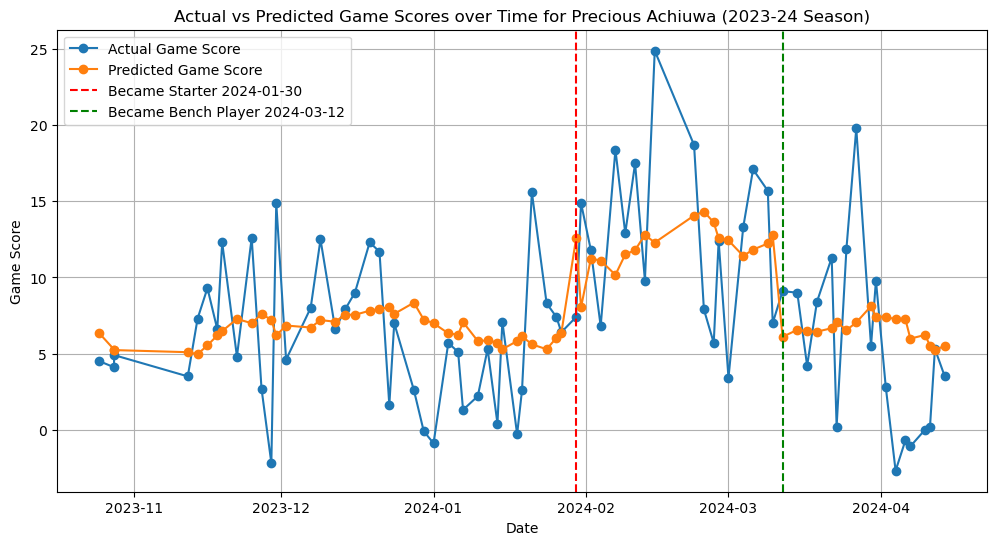

In [21]:
example_player_df = df[df['playerId'] == 1630173]  # This is Precious Achuiwa's gamelogs

# Predict gamescore for each row
example_player_df['predictedGamescore'] = example_player_df.apply(lambda row: predict_gamescore(row), axis=1)

# Get all the games played in the most recent season for the player
example_player_df = (example_player_df[example_player_df['season'] == max(df['season'].unique())]
                    .sort_values(by='dateUTC'))

# Convert the 'date' column to datetime format
example_player_df['dateUTC'] = pd.to_datetime(example_player_df['dateUTC'])

# Set the 'date' column as the index
example_player_df.set_index('dateUTC', inplace=True)

# Plot the actual and predicted game scores over time
plt.figure(figsize=(12, 6))
plt.plot(example_player_df.index, example_player_df['gamescore'], label='Actual Game Score', 
         marker='o')
plt.plot(example_player_df.index, example_player_df['predictedGamescore'], 
         label='Predicted Game Score', marker='o')

# Plot the date when Julius Randle got injured. After Randle got injured, Achiuwa became a starter.
plt.axvline(x=pd.Timestamp('2024-01-30'), color='r', linestyle='--', 
            label='Became Starter 2024-01-30')

# Plot the date when Achiuwa became a bench player again.
plt.axvline(x=pd.Timestamp('2024-03-12'), color='g', linestyle='--', 
            label='Became Bench Player 2024-03-12')

plt.xlabel('Date')
plt.ylabel('Game Score')
plt.title('Actual vs Predicted Game Scores over Time for Precious Achiuwa (2023-24 Season)')
plt.legend()
plt.grid(True)
plt.show()